In [ ]:
# === Cell 1: Setup & sanity checks ===
import os, re, json, math, random, sys, platform
from collections import Counter, defaultdict
from dataclasses import dataclass

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from tqdm import tqdm

from pathlib import Path

# Reproducibility
SEED = 42
def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(SEED)

# Device & perf
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
if hasattr(torch, "set_float32_matmul_precision"):
    torch.set_float32_matmul_precision("high")
torch.backends.cudnn.benchmark = True



# Small helpers
def human_bool(x: bool) -> str: return "yes" if x else "no"
def short(x, n=120):
    s = str(x)
    return s if len(s) <= n else s[:n-3] + "..."

def check_tensor_ops():
    # minimal tensor roundtrip to ensure device works
    x = torch.randn(4, 5, device=DEVICE)
    y = torch.randn(5, 6, device=DEVICE)
    z = x @ y  # (4,6)
    return tuple(z.shape), float(z.abs().mean().item())

# Versions / environment printout
print("=== Environment ===")
print(f"Python:     {sys.version.split()[0]} | {platform.system()} {platform.release()}")
print(f"Numpy:      {np.__version__}")
print(f"Pandas:     {pd.__version__}")
print(f"Torch:      {torch.__version__}")
print(f"CUDA avail: {human_bool(torch.cuda.is_available())}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")
    print(f"CUDA cap:    {torch.cuda.get_device_capability(0)}")
print(f"DEVICE:     {DEVICE}")

# Sanity: tensor math on selected device
shape, mean_abs = check_tensor_ops()
print("Sanity tensor matmul:", shape, "| mean(|z|)≈", round(mean_abs, 4))

# File-system sanity (writable?)
test_path = "artifacts/_fs_sanity.txt"
with open(test_path, "w", encoding="utf-8") as f:
    f.write("ok")
print("FS writable:", os.path.exists(test_path))

# Determinism note (optional): uncomment for stricter determinism, may reduce throughput
# torch.use_deterministic_algorithms(True)
# os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"

# If something looks off, raise a visible warning
assert shape == (4, 6), "Unexpected matmul shape; check Torch install / DEVICE."
assert os.path.exists(test_path), "Cannot write to artifacts/ — check permissions."

# Everything ready
print("Setup OK.")


=== Environment ===
Python:     3.12.8 | Windows 11
Numpy:      2.3.3
Pandas:     2.3.2
Torch:      2.8.0+cu126
CUDA avail: yes
CUDA device: NVIDIA GeForce RTX 4060 Laptop GPU
CUDA cap:    (8, 9)
DEVICE:     cuda
Sanity tensor matmul: (4, 6) | mean(|z|)≈ 1.4062
FS writable: True
Setup OK.


In [2]:
# === Cell 2: Load data (Avito CSV), clean, split, build char vocab ===
import json
from collections import Counter

# ---- Config (adjust if needed) ----
AVITO_CSV_PATH = "../data/train.csv"   # <-- укажи свой путь к CSV
TITLE_COL      = "title"       # <-- имя колонки с текстами
CSV_DELIM      = ","           # ";" если нужно
VAL_FRACTION   = 0.05          # доля на валидацию
MIN_LEN        = 3             # минимальная длина строки с пробелами
MAX_LEN        = 160           # максимальная длина строки с пробелами
SAMPLE_MAX     = None          # например, 500_000 чтобы ограничить размер
VOCAB_MAX      = 8000          # размер словаря символов (включая спецтокены)
VOCAB_PATH     = "artifacts/vocab.json"
TRAIN_TXT      = "../data/train.txt"
VAL_TXT        = "../data/val.txt"

def _clean_title(s: str) -> str:
    s = (s or "")
    s = s.replace("\xa0", " ")
    s = re.sub(r"https?://\S+", "", s)      # убрать URL
    s = re.sub(r"\s+", " ", s).strip()
    return s

def build_char_vocab(lines, max_vocab=8000):
    # частоты по символам
    cnt = Counter("".join(lines))
    # спецтокены
    stoi = {"<pad>": 0, "<unk>": 1}
    # оставляем топ-(max_vocab-2) символов
    for i, (ch, _) in enumerate(cnt.most_common(max_vocab - 2), start=2):
        stoi[ch] = i
    itos = {i: ch for ch, i in stoi.items()}
    return stoi, itos, cnt

# ---- Read & clean ----
print("Reading CSV:", AVITO_CSV_PATH)
df = pd.read_csv(AVITO_CSV_PATH, delimiter=CSV_DELIM, usecols=[TITLE_COL])
before = len(df)
df = df.dropna(subset=[TITLE_COL])
after_na = len(df)

titles = df[TITLE_COL].astype(str).map(_clean_title)
mask_len  = titles.str.len().between(MIN_LEN, MAX_LEN)
mask_chars = titles.map(lambda s: any(ch.isalnum() for ch in s))
titles = titles[mask_len & mask_chars].drop_duplicates()

# Optional subsample
if SAMPLE_MAX is not None and len(titles) > SAMPLE_MAX:
    titles = titles.sample(SAMPLE_MAX, random_state=SEED)

titles = titles.sample(frac=1.0, random_state=SEED).tolist()
n_total = len(titles)
split = int((1 - VAL_FRACTION) * n_total)
train_lines = titles[:split]
val_lines   = titles[split:]

# ---- Save plain train/val for reference ----
with open(TRAIN_TXT, "w", encoding="utf-8") as f:
    for s in train_lines: f.write(s + "\n")
with open(VAL_TXT, "w", encoding="utf-8") as f:
    for s in val_lines: f.write(s + "\n")

# ---- Build and save char vocab ----
stoi, itos, char_freq = build_char_vocab(train_lines, max_vocab=VOCAB_MAX)
with open(VOCAB_PATH, "w", encoding="utf-8") as f:
    json.dump({"stoi": stoi, "itos": itos}, f, ensure_ascii=False)

# ---- Sanity checks & quick stats ----
print("=== Data stats ===")
print(f"Rows in CSV (raw):         {before}")
print(f"After dropna:              {after_na}")
print(f"After filters+dedup:       {n_total}")
print(f"Train/Val split:           {len(train_lines)} / {len(val_lines)}  (val={VAL_FRACTION:.0%})")
print(f"Saved: {TRAIN_TXT}, {VAL_TXT}")

print("\nSample train lines:")
for s in train_lines[:5]:
    print("  •", s)

# Vocab sanity
print("\n=== Vocab stats ===")
print(f"Vocab size (incl <pad>,<unk>): {len(stoi)} (max {VOCAB_MAX})")
top20 = char_freq.most_common(20)
print("Top-20 chars by freq:")
print(" ", ", ".join([repr(c) + ":" + str(n) for c, n in top20]))

# Basic coverage check on val: доля символов, попавших в vocab (не считая <unk>)
def coverage(lines, stoi):
    known = total = 0
    for s in lines:
        for ch in s:
            total += 1
            if ch in stoi: known += 1
    return known / max(1, total)

cov_train = coverage(train_lines[:10000], stoi)  # быстрый эстимейт
cov_val   = coverage(val_lines[:10000],   stoi)
print(f"\nCoverage (train sample): {cov_train:.4f}")
print(f"Coverage (val   sample): {cov_val:.4f}")
assert len(stoi) >= 100 and cov_val > 0.95, "Vocab looks too small or coverage too low — check data/filters."

print("\nVocab saved to:", VOCAB_PATH)

import os
os.makedirs("artifacts", exist_ok=True)
rho_train = float(np.mean([(s.count(" ")) / max(1, len(s)-1) for s in train_lines if len(s) > 1]))
rho_val   = float(np.mean([(s.count(" ")) / max(1, len(s)-1) for s in val_lines   if len(s) > 1]))
with open("artifacts/data_stats.json", "w", encoding="utf-8") as f:
    json.dump({
        "n_total": int(n_total),
        "n_train": int(len(train_lines)),
        "n_val":   int(len(val_lines)),
        "vocab_size": int(len(stoi)),
        "rho_mean_train": rho_train,
        "rho_mean_val":   rho_val,
    }, f, ensure_ascii=False, indent=2)
print(f"\nSaved stats to artifacts/data_stats.json (rho_train={rho_train:.3f})")



Reading CSV: ../data/train.csv
=== Data stats ===
Rows in CSV (raw):         1503424
After dropna:              1503424
After filters+dedup:       788254
Train/Val split:           748841 / 39413  (val=5%)
Saved: ../data/train.txt, ../data/val.txt

Sample train lines:
  • Стиральная машина Candy на 4кг
  • Инкубатор Несушка №34 63 яйца,220В,авт.поворот
  • Развивающая дорога
  • Shaik M 65 givenchy Blue Label
  • Fly iq449 модуль (белый)

=== Vocab stats ===
Vocab size (incl <pad>,<unk>): 156 (max 8000)
Top-20 chars by freq:
  ' ':2284828, 'а':1248350, 'о':1248169, 'е':969904, 'и':892117, 'н':834257, 'р':780555, 'к':779991, 'т':746632, 'л':581884, 'с':569901, 'м':458281, 'в':443858, 'д':392178, 'у':318936, 'я':282018, 'ы':279391, 'п':256527, 'й':198262, 'б':196080

Coverage (train sample): 1.0000
Coverage (val   sample): 1.0000

Vocab saved to: artifacts/vocab.json

Saved stats to artifacts/data_stats.json (rho_train=0.114)


In [3]:
# === Cell 3: Build boundary dataset (char-level), encoders, loaders — NN-only path ===
import json
from typing import List, Tuple

# ---- Config ----
MAX_LEN       = 160
BATCH_TRAIN   = 128
BATCH_VAL     = 256
NUM_WORKERS   = 4
PIN_MEMORY    = True


VOCAB_PATH= "artifacts/vocab.json"

# ---- Load vocab ----
with open(VOCAB_PATH, "r", encoding="utf-8") as f:
    voc = json.load(f)
STOI = {k:int(v) for k,v in voc["stoi"].items()}  # ensure ints
PAD_ID = STOI.get("<pad>", 0)
UNK_ID = STOI.get("<unk>", 1)
VOCAB_SIZE = max(STOI.values()) + 1

print(f"Vocab loaded: size={VOCAB_SIZE}, PAD_ID={PAD_ID}, UNK_ID={UNK_ID}")

# ---- Helpers: build (no_space, labels) from spaced text ----
def make_pair_from_spaced(s: str) -> Tuple[str, np.ndarray]:
    """
    Input:  'куплю айфон 14 про'
    Output: 'куплюайфон14про', labels: len=n-1 (1 if there was a space between i and i+1)
    """
    s = s.strip()
    no_space = s.replace(" ", "")
    n = len(no_space)
    y = np.zeros(max(n-1, 0), dtype=np.int64)
    if n <= 1:
        return no_space, y
    i_ns = 0
    prev_space = False
    for ch in s:
        if ch == " ":
            prev_space = True
            continue
        if prev_space and i_ns > 0:
            y[i_ns-1] = 1
        prev_space = False
        i_ns += 1
    return no_space, y

def encode_chars(s: str) -> np.ndarray:
    return np.array([STOI.get(ch, UNK_ID) for ch in s], dtype=np.int32)

# ---- Dataset ----
class BoundaryDataset(Dataset):
    def __init__(self, lines: List[str], max_len: int = 160):
        self.items = []
        for ln in lines:
            s = str(ln).strip()
            if not s: 
                continue
            x_str, y = make_pair_from_spaced(s)
            if len(x_str) < 2:
                continue
            # clip
            if len(x_str) > max_len:
                x_str = x_str[:max_len]
                y     = y[:max_len-1]
            x_ids = encode_chars(x_str)
            self.items.append((x_ids, y))
    def __len__(self):
        return len(self.items)
    def __getitem__(self, idx):
        x, y = self.items[idx]
        return torch.from_numpy(x), torch.from_numpy(y)

def collate_batch(batch, pad_id: int = 0):
    # batch: list of (x_ids[int32][L], y[int64][L-1])
    B = len(batch)
    maxL = max(int(len(x)) for x,_ in batch)
    x_pad = torch.full((B, maxL), pad_id, dtype=torch.long)
    y_pad = torch.full((B, max(1, maxL-1)), -100, dtype=torch.long)  # -100 -> ignore_index
    mask  = torch.zeros((B, maxL), dtype=torch.bool)
    for i,(x,y) in enumerate(batch):
        L = int(len(x))
        x_pad[i, :L] = x
        mask[i, :L]  = True
        if L > 1:
            y_pad[i, :L-1] = y
    return x_pad, y_pad, mask

# ---- Load train/val lines ----
with open(TRAIN_TXT, "r", encoding="utf-8") as f:
    train_lines = [ln.rstrip("\n") for ln in f]
with open(VAL_TXT, "r", encoding="utf-8") as f:
    val_lines   = [ln.rstrip("\n") for ln in f]

# ---- Build datasets ----
train_ds = BoundaryDataset(train_lines, max_len=MAX_LEN)
val_ds   = BoundaryDataset(val_lines,   max_len=MAX_LEN)

train_dl = DataLoader(
    train_ds, batch_size=BATCH_TRAIN, shuffle=True,
    collate_fn=collate_batch
)
val_dl = DataLoader(
    val_ds, batch_size=BATCH_VAL, shuffle=False,
    collate_fn=collate_batch
)

# ---- Sanity checks ----
print("=== Dataset stats ===")
print(f"Train items: {len(train_ds)} | Val items: {len(val_ds)} | MaxLen: {MAX_LEN}")

# Peek a couple of items
for i in range(2):
    xi, yi = train_ds[i]
    print(f"Sample[{i}] len(x)={len(xi)}, len(y)={len(yi)}, y_pos_rate={(yi.float().mean().item() if len(yi)>0 else float('nan')):.3f}")

# Batch sanity
# xb, yb, mb = next(iter(train_dl))
# print("Batch shapes:", xb.shape, yb.shape, mb.shape, "| dtype:", xb.dtype, yb.dtype, mb.dtype)
# assert xb.ndim==2 and yb.ndim==2 and mb.ndim==2, "Unexpected batch shapes."
print('here')
# Class balance estimation on a subset
def estimate_pos_ratio(dloader, max_batches=5):
    pos = neg = 0
    for b,(x,y,m) in tqdm(enumerate(dloader)):
        if b>=max_batches: break
        valid = (y != -100) & (m[:,:-1])
        if valid.any():
            pos += int((y[valid]==1).sum())
            neg += int((y[valid]==0).sum())
    tot = pos+neg
    return (pos/tot if tot else 0.0), pos, neg, tot

pos_ratio, pos_cnt, neg_cnt, tot_cnt = estimate_pos_ratio(train_dl, max_batches=20)
print(f"Pos-ratio (train subset): {pos_ratio:.4f}  | pos={pos_cnt}, neg={neg_cnt}, tot={tot_cnt}")

# pos_weight for BCE
if pos_cnt>0:
    POS_WEIGHT = torch.tensor([neg_cnt/pos_cnt], device=DEVICE, dtype=torch.float32)
else:
    POS_WEIGHT = torch.tensor([1.0], device=DEVICE, dtype=torch.float32)

print("pos_weight (neg/pos):", round(float(POS_WEIGHT.item()), 3))
assert VOCAB_SIZE >= 100, "Vocab unexpectedly small."
print("Dataset & loaders OK.")


Vocab loaded: size=156, PAD_ID=0, UNK_ID=1
=== Dataset stats ===
Train items: 748841 | Val items: 39413 | MaxLen: 160
Sample[0] len(x)=26, len(y)=25, y_pos_rate=0.160
Sample[1] len(x)=42, len(y)=41, y_pos_rate=0.098
here


20it [00:00, 162.10it/s]

Pos-ratio (train subset): 0.1325  | pos=7800, neg=51068, tot=58868
pos_weight (neg/pos): 6.547
Dataset & loaders OK.


In [ ]:
from math import prod

EMB_DIM    = 128
HID_CH     = 256
N_LAYERS   = 5
KERNEL     = 5
DROPOUT    = 0.05
EMB_DROPOUT= 0.05

class SpatialDrop1D(nn.Dropout2d):
    """Channel-wise dropout for (B, C, L)."""
    def forward(self, x): 
        return super().forward(x.unsqueeze(-1)).squeeze(-1)

class GatedTCNBlock(nn.Module):
    """Residual gated TCN block with same in/out channels."""
    def __init__(self, ch, k=5, dilation=1, p=0.05):
        super().__init__()
        pad = dilation * (k - 1) // 2
        self.conv_f = nn.Conv1d(ch, ch, k, padding=pad, dilation=dilation)
        self.conv_g = nn.Conv1d(ch, ch, k, padding=pad, dilation=dilation)
        self.drop   = nn.Dropout(p)
        self.ln     = nn.LayerNorm(ch)  # LN over channels after transpose

    def forward(self, x):  # x: (B,C,L)
        f = self.conv_f(x)
        g = self.conv_g(x)
        h = torch.tanh(f) * torch.sigmoid(g)
        y = x + self.drop(h)
        return self.ln(y.transpose(1,2)).transpose(1,2)

class CharTCNPP(nn.Module):
    def __init__(self, vocab_size, emb_dim=128, hid=256, n_layers=5, kernel=5, dropout=0.05, pad_id=0):
        super().__init__()
        self.emb      = nn.Embedding(vocab_size, emb_dim, padding_idx=pad_id)
        self.emb_drop = nn.Dropout(EMB_DROPOUT)

        self.inproj = nn.Conv1d(emb_dim, hid, 1)
        self.sdrop  = SpatialDrop1D(p=EMB_DROPOUT)

        layers = []
        dil = 1
        for _ in range(n_layers):
            layers.append(GatedTCNBlock(ch=hid, k=kernel, dilation=dil, p=dropout))
            dil *= 2
        self.tcn = nn.Sequential(*layers)

        self.bilstm = nn.LSTM(
            input_size=2*hid,
            hidden_size=hid,
            num_layers=1,
            bidirectional=True,
            batch_first=True,
        )

        self.head = nn.Sequential(
            nn.Linear(2*hid, hid),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hid, 1),
        )

    def forward(self, x, mask):
        e = self.emb(x)
        e = self.emb_drop(e)
        h = e.transpose(1, 2)
        h = self.inproj(h)
        h = self.sdrop(h)
        h = self.tcn(h)

        left  = h[:, :, :-1]
        right = h[:, :, 1:]
        mid = torch.cat([left, right], dim=1).transpose(1, 2)

        # BiLSTM по межсимвольным позициям
        mid, _ = self.bilstm(mid)       # (B,L-1, 2H)

        logits = self.head(mid).squeeze(-1)   # (B,L-1)
        inter_mask = (mask[:, :-1] & mask[:, 1:])
        return logits, inter_mask

def count_parameters(model: nn.Module) -> int:
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

class FocalLoss(nn.Module):
    def __init__(self, alpha=1.0, gamma=2.0, reduction="mean"):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
        self.bce = nn.BCEWithLogitsLoss(reduction="none")

    def forward(self, logits, targets):
        bce = self.bce(logits, targets)
        p   = torch.sigmoid(logits)
        pt  = p*targets + (1-p)*(1-targets)
        loss = (self.alpha * (1-pt).pow(self.gamma) * bce)
        if self.reduction == "mean":
            return loss.mean()
        elif self.reduction == "sum":
            return loss.sum()
        return loss

model = CharTCNPP(
    vocab_size=VOCAB_SIZE,
    emb_dim=EMB_DIM,
    hid=HID_CH,
    n_layers=N_LAYERS,
    kernel=KERNEL,
    dropout=DROPOUT,
    pad_id=PAD_ID
).to(DEVICE)

LOSS_ALPHA = 1.0
LOSS_GAMMA = 2.0
loss_fn = FocalLoss(alpha=LOSS_ALPHA, gamma=LOSS_GAMMA)

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-2)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=1000)

#Sanity forward pass
model.train()
xb, yb, mb = next(iter(train_dl))
xb = xb.to(DEVICE); yb = yb.to(DEVICE); mb = mb.to(DEVICE)
logits, inter_mask = model(xb, mb)
valid = (yb != -100) & inter_mask

print("Logits shape:", tuple(logits.shape), "| inter_mask:", tuple(inter_mask.shape))
if valid.any():
    loss = loss_fn(logits[valid], yb[valid].float())
    print("Sanity loss:", float(loss.item()))
else:
    print("No valid positions in this mini-batch (unexpected).")

print(f"Trainable params: {count_parameters(model)/1e6:.3f}M")
assert torch.isfinite(logits).all(), "Logits contain NaN/Inf"
print("Model init & forward OK.")


Logits shape: (128, 42) | inter_mask: (128, 42)
Sanity loss: 0.16384349763393402
Trainable params: 5.043M
Model init & forward OK.


## Тренировочный цикл

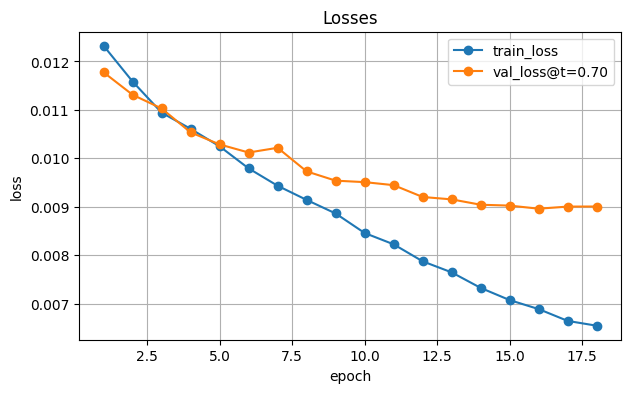

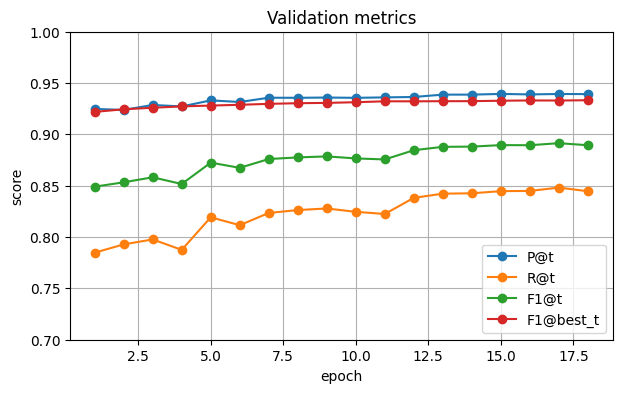

Train ep19:   0%|          | 0/1000 [00:00<?, ?it/s]

[ep 19/20] train_loss=0.0064 | val@0.70: F1=0.8915 | best_t=0.45 → F1(best)=0.9334


Train ep20:   0%|          | 0/1000 [00:00<?, ?it/s]

[ep 20/20] train_loss=0.0064 | val@0.70: F1=0.8916 | best_t=0.45 → F1(best)=0.9334

Finished in 1238.1s | Best: F1=0.9334 @ t=0.45 (epoch 20)
Best ckpt: artifacts_lstm_last\char_tcnpp_best_lstm_last.pt | Last ckpt: artifacts_lstm_last\char_tcnpp_last_lstm_last.pt


In [ ]:
import os, json, math, time
from itertools import islice
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output, display

CKPT_DIR        = "artifacts_lstm_last"
BEST_CKPT_PATH  = os.path.join(CKPT_DIR, "char_tcnpp_best_lstm_last.pt")
LAST_CKPT_PATH  = os.path.join(CKPT_DIR, "char_tcnpp_last_lstm_last.pt")
HISTORY_PATH    = os.path.join(CKPT_DIR, "train_history_lstm_last.json")
os.makedirs(CKPT_DIR, exist_ok=True)

# --- Config ---
EPOCHS            = 20
THRESH_INIT       = 0.70
MAX_TRAIN_BATCHES = 1000      # set None for full epoch
MAX_VAL_BATCHES   = 500
PLOT_EVERY        = 3         # реже рисуем графики, чтобы ускорить ноут
USE_AMP = torch.cuda.is_available()
scaler  = torch.cuda.amp.GradScaler(enabled=USE_AMP)

EMA_DECAY = 0.999
ema_state = None

def ema_init(model):
    return {k: v.detach().clone() for k, v in model.state_dict().items()}

@torch.no_grad()
def ema_update(model, ema, decay=EMA_DECAY):
    for k, v in model.state_dict().items():
        ema[k].mul_(decay).add_(v, alpha=1 - decay)

# Подмена весов на EMA один раз на всю валидацию (и обратный откат)
def swap_to_ema(model, ema_sd):
    saved = {k: v.detach().clone() for k, v in model.state_dict().items()}
    model.load_state_dict(ema_sd, strict=False)
    return saved

def restore_from_saved(model, saved_sd):
    model.load_state_dict(saved_sd, strict=False)

def load_history(path=HISTORY_PATH):
    if os.path.exists(path):
        with open(path, "r", encoding="utf-8") as f:
            h = json.load(f)
        for k in ["epoch","train_loss","val_loss@t","val_p@t","val_r@t","val_f1@t","best_t","val_f1@best_t"]:
            h.setdefault(k, [])
        return h
    return {"epoch": [], "train_loss": [], "val_loss@t": [], "val_p@t": [], "val_r@t": [],
            "val_f1@t": [], "best_t": [], "val_f1@best_t": []}

def save_history(hist, path=HISTORY_PATH):
    with open(path, "w", encoding="utf-8") as f:
        json.dump(hist, f, ensure_ascii=False)

history = load_history()

def plot_history(hist):
    clear_output(wait=True)
    xs = hist["epoch"]

    plt.figure(figsize=(7,4))
    if xs:
        plt.plot(xs, hist["train_loss"], marker="o", label="train_loss")
        plt.plot(xs, hist["val_loss@t"], marker="o", label=f"val_loss@t={THRESH_INIT:.2f}")
        plt.title("Losses"); plt.xlabel("epoch"); plt.ylabel("loss")
        plt.legend(); plt.grid(True)
    display(plt.gcf()); plt.close()

    plt.figure(figsize=(7,4))
    if xs:
        plt.plot(xs, hist["val_p@t"], marker="o", label="P@t")
        plt.plot(xs, hist["val_r@t"], marker="o", label="R@t")
        plt.plot(xs, hist["val_f1@t"], marker="o", label="F1@t")
        plt.plot(xs, hist["val_f1@best_t"], marker="o", label="F1@best_t")
        plt.title("Validation metrics"); plt.xlabel("epoch"); plt.ylabel("score")
        plt.ylim(0.70, 1.0); plt.legend(); plt.grid(True)
    display(plt.gcf()); plt.close()

def save_checkpoint(path, model, optimizer, scheduler, scaler, epoch, best_snapshot, note):
    state = {
        "model_state": model.state_dict(),
        "optimizer_state": optimizer.state_dict(),
        "scheduler_state": scheduler.state_dict() if scheduler else None,
        "scaler_state": scaler.state_dict() if scaler else None,
        "epoch": epoch,
        "best_snapshot": best_snapshot,
        "hparams": {
            "EMB_DIM": EMB_DIM, "HID_CH": HID_CH, "N_LAYERS": N_LAYERS,
            "KERNEL": KERNEL, "DROPOUT": DROPOUT,
            "VOCAB_SIZE": VOCAB_SIZE, "PAD_ID": PAD_ID,
        },
        "note": note,
        "timestamp": time.time(),
        "seed": SEED,
    }
    torch.save(state, path)

def load_checkpoint(path, model, optimizer, scheduler, scaler):
    ckpt = torch.load(path, map_location=DEVICE)
    model.load_state_dict(ckpt["model_state"])
    if optimizer is not None and ckpt.get("optimizer_state") is not None:
        optimizer.load_state_dict(ckpt["optimizer_state"])
    if scheduler is not None and ckpt.get("scheduler_state") is not None:
        scheduler.load_state_dict(ckpt["scheduler_state"])
    if scaler is not None and ckpt.get("scaler_state") is not None:
        scaler.load_state_dict(ckpt["scaler_state"])
    start_epoch   = ckpt.get("epoch", 0)
    best_snapshot = ckpt.get("best_snapshot", {"f1": -1.0, "t": THRESH_INIT, "epoch": 0})
    return start_epoch, best_snapshot

def train_epoch_amp(model, loader, optimizer, loss_fn, scaler, epoch_idx=1, max_batches=None):
    model.train()
    tot_loss = 0.0; steps = 0
    total_steps = (max_batches if max_batches is not None else len(loader))
    try:
        from tqdm.auto import tqdm
        iterator = tqdm(islice(enumerate(loader), 0, total_steps), total=total_steps, leave=False, desc=f"Train ep{epoch_idx}")
    except Exception:
        iterator = islice(enumerate(loader), 0, total_steps)

    optimizer.zero_grad(set_to_none=True)
    for b, (x, y, m) in iterator:
        x = x.to(DEVICE, non_blocking=True)
        y = y.to(DEVICE, non_blocking=True)
        m = m.to(DEVICE, non_blocking=True)
        with torch.cuda.amp.autocast(enabled=USE_AMP):
            logits, inter_mask = model(x, m)
            valid = (y != -100) & inter_mask
            if not valid.any():
                continue
            loss = loss_fn(logits[valid], y[valid].float())
        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        scaler.step(optimizer); scaler.update()
        optimizer.zero_grad(set_to_none=True)

        ema_update(model, ema_state)

        if math.isfinite(float(loss)):
            tot_loss += float(loss); steps += 1
    return tot_loss / max(1, steps)

@torch.no_grad()
def eval_collect(model, loader, loss_fn, max_batches=None):
    model.eval()
    tot_loss=0.0; steps=0
    ys=[]; probs=[]; masks=[]
    total_steps = (max_batches if max_batches is not None else len(loader))
    it = islice(enumerate(loader), 0, total_steps)
    for _, (x, y, m) in it:
        x=x.to(DEVICE); y=y.to(DEVICE); m=m.to(DEVICE)
        logits, inter_mask = model(x, m)
        valid = (y != -100) & inter_mask
        if not valid.any():
            continue
        loss = loss_fn(logits[valid], y[valid].float())
        if math.isfinite(float(loss)): 
            tot_loss += float(loss); steps += 1

        p = torch.sigmoid(logits).detach().cpu()
        ys.append(y.detach().cpu()); probs.append(p); masks.append(valid.detach().cpu())
    val_loss = tot_loss / max(1, steps)
    return val_loss, ys, probs, masks

def seq_f1_from_cache(ys, probs, masks, threshold: float):
    ps=[]; rs=[]
    for y, p, vmask in zip(ys, probs, masks):
        B = y.size(0)
        for i in range(B):
            vm = vmask[i]
            if not vm.any(): 
                continue
            yi = y[i][vm].view(-1).numpy()
            pi = (p[i][vm].view(-1).numpy() > threshold).astype(np.uint8)
            T = set(np.where(yi==1)[0].astype(int))
            P = set(np.where(pi==1)[0].astype(int))
            inter = len(T & P)
            prec = inter/len(P) if len(P)>0 else 0.0
            rec  = inter/len(T) if len(T)>0 else 0.0
            if (prec+rec)>0: 
                ps.append(prec); rs.append(rec)
            else:
                ps.append(0.0); rs.append(0.0)
    P = float(np.mean(ps) if ps else 0.0)
    R = float(np.mean(rs) if rs else 0.0)
    F1 = 2*P*R/(P+R) if (P+R)>0 else 0.0
    return P, R, F1

def sweep_threshold_coarse_cached(ys, probs, masks, grid=(0.45, 0.80, 0.05)):
    best=(-1.0, grid[0])
    t_min, t_max, t_step = grid
    for t in np.arange(t_min, t_max+1e-9, t_step):
        P,R,F1 = seq_f1_from_cache(ys, probs, masks, float(t))
        if F1 > best[0]:
            best = (F1, float(t))
    return best

if os.path.exists(LAST_CKPT_PATH):
    start_epoch, best_snapshot = load_checkpoint(LAST_CKPT_PATH, model, optimizer, scheduler=None, scaler=scaler)
    print(f"[RESUME] Loaded LAST checkpoint @ epoch {start_epoch}. Best so far: F1={best_snapshot['f1']:.4f} @ t={best_snapshot['t']:.2f} (ep {best_snapshot['epoch']})")
else:
    start_epoch = 0
    best_snapshot = {"f1": -1.0, "t": THRESH_INIT, "epoch": 0}
    print("[RESUME] No LAST checkpoint. Starting from scratch.")

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

ema_state = ema_init(model)

t0 = time.time()
for ep in range(start_epoch+1, EPOCHS+1):
    tr_loss = train_epoch_amp(model, train_dl, optimizer, loss_fn, scaler, epoch_idx=ep, max_batches=MAX_TRAIN_BATCHES)
    scheduler.step()

    val_loss, ys, probs, masks = eval_collect(model, val_dl, loss_fn, MAX_VAL_BATCHES)
    p_at_t, r_at_t, f1_at_t = seq_f1_from_cache(ys, probs, masks, THRESH_INIT)
    best_f1, best_t = sweep_threshold_coarse_cached(ys, probs, masks, (0.45, 0.80, 0.05))

    saved_sd = swap_to_ema(model, ema_state)
    _, ys_e, probs_e, masks_e = eval_collect(model, val_dl, loss_fn, MAX_VAL_BATCHES)
    restore_from_saved(model, saved_sd)
    _, _, f1_ema = seq_f1_from_cache(ys_e, probs_e, masks_e, best_t)
    if f1_ema > best_f1:
        best_f1 = f1_ema  # логируем лучший

    # история / логи
    history["epoch"].append(ep)
    history["train_loss"].append(tr_loss)
    history["val_loss@t"].append(val_loss)
    history["val_p@t"].append(p_at_t)
    history["val_r@t"].append(r_at_t)
    history["val_f1@t"].append(f1_at_t)
    history["best_t"].append(best_t)
    history["val_f1@best_t"].append(best_f1)
    save_history(history)

    # чекпойнты
    save_checkpoint(LAST_CKPT_PATH, model, optimizer, scheduler, scaler, ep, best_snapshot, note="last")
    if best_f1 > best_snapshot["f1"]:
        best_snapshot = {"f1": best_f1, "t": best_t, "epoch": ep}
        save_checkpoint(BEST_CKPT_PATH, model, optimizer, scheduler, scaler, ep, best_snapshot, note="best")

    print(f"[ep {ep}/{EPOCHS}] train_loss={tr_loss:.4f} | "
          f"val@{THRESH_INIT:.2f}: F1={f1_at_t:.4f} | best_t={best_t:.2f} → F1(best)={best_f1:.4f}")

    if ep % PLOT_EVERY == 0:
        plot_history(history)

print(f"\nFinished in {time.time()-t0:.1f}s | Best: F1={best_snapshot['f1']:.4f} @ t={best_snapshot['t']:.2f} (epoch {best_snapshot['epoch']})")
print("Best ckpt:", BEST_CKPT_PATH, "| Last ckpt:", LAST_CKPT_PATH)


## Загрузка модели

In [5]:
# === Safe CPU restore (fresh model), quantized inference, sanity check ===
import torch, json, os
import torch.nn as nn

BEST_CKPT_PATH = r"artifacts_lstm_last\char_tcnpp_best_lstm_last.pt"

def build_fresh_cpu_model():
    # создаём НОВЫЙ экземпляр на CPU с теми же гиперпараметрами
    fresh = CharTCNPP(
        vocab_size=VOCAB_SIZE,
        emb_dim=EMB_DIM,
        hid=HID_CH,
        n_layers=N_LAYERS,
        kernel=KERNEL,
        dropout=DROPOUT,
        pad_id=PAD_ID
    )
    fresh.eval()
    return fresh

def load_state_cpu(fresh_model, path=BEST_CKPT_PATH):
    # грузим чекпойнт на CPU и заливаем state_dict в свежую модель (без касания CUDA)
    ckpt = torch.load(path, map_location="cpu")
    hp = ckpt.get("hparams", {})
    # быстрый sanity по основным гиперпарам
    mism = []
    for k, cur, sav in [
        ("VOCAB_SIZE", VOCAB_SIZE, hp.get("VOCAB_SIZE")),
        ("PAD_ID", PAD_ID, hp.get("PAD_ID")),
        ("EMB_DIM", EMB_DIM, hp.get("EMB_DIM")),
        ("HID_CH", HID_CH, hp.get("HID_CH")),
        ("N_LAYERS", N_LAYERS, hp.get("N_LAYERS")),
        ("KERNEL", KERNEL, hp.get("KERNEL")),
        ("DROPOUT", DROPOUT, hp.get("DROPOUT")),
    ]:
        if sav is not None and cur != sav:
            mism.append((k, cur, sav))
    if mism:
        print("[warn] hparams mismatch (current vs saved):")
        for k, cur, sav in mism:
            print(f"  {k}: current={cur} | saved={sav}")

    fresh_model.load_state_dict(ckpt["model_state"], strict=True)
    best_t = float(ckpt.get("best_snapshot", {}).get("t", 0.80))
    return best_t

# 1) НЕ трогаем старый model (на GPU). Создаём новый CPU-модель и грузим веса.
fresh_cpu_model = build_fresh_cpu_model()
best_t = load_state_cpu(fresh_cpu_model, BEST_CKPT_PATH)
print(f"[loaded CPU] {BEST_CKPT_PATH} | best_t={best_t:.2f}")

# 2) Динамическая квантизация для ускорения CPU-инференса
try:
    model_inf = torch.quantization.quantize_dynamic(fresh_cpu_model, {nn.Linear}, dtype=torch.qint8)
    print("[quant] dynamic quantization applied to Linear layers")
except Exception as e:
    print("[quant] skipped:", e)
    model_inf = fresh_cpu_model

# 3) Санити-форвард (CPU)
with torch.no_grad():
    ex = torch.tensor([[STOI.get('к', UNK_ID), STOI.get('о', UNK_ID), STOI.get('т', UNK_ID)]], dtype=torch.long)
    ex_mask = torch.ones_like(ex, dtype=torch.bool)
    lg, im = model_inf(ex, ex_mask)
    assert torch.isfinite(lg).all(), "Non-finite logits after load"
print("[sanity] CPU forward OK.")

# 4) Готовим функции инференса (используем model_inf на CPU)
def logits_for_texts_cpu(texts, batch=512):
    outs = []
    for i in range(0, len(texts), batch):
        chunk = texts[i:i+batch]
        seqs = [torch.tensor([STOI.get(ch, UNK_ID) for ch in s], dtype=torch.long) for s in chunk]
        maxL = max(len(t) for t in seqs) if seqs else 1
        xb   = torch.full((len(seqs), maxL), PAD_ID, dtype=torch.long)
        mb   = torch.zeros((len(seqs), maxL), dtype=torch.bool)
        for r,t in enumerate(seqs):
            L = len(t); xb[r,:L] = t; mb[r,:L] = True
        with torch.no_grad():
            lg, inter_mask = model_inf(xb, mb)
            lg = lg.numpy(); im = inter_mask.numpy()
            for r in range(len(chunk)):
                L = int(mb[r].sum().item())
                outs.append(lg[r, :max(L-1, 0)])
    return outs

def decode_from_logits(s, lg, t):
    import numpy as np
    probs = 1/(1+np.exp(-lg))
    pred = probs > t
    out=[]; pos=[]
    for i,ch in enumerate(s):
        out.append(ch)
        if i < len(s)-1 and pred[i]:
            out.append(" "); pos.append(i+1)
    return "".join(out), pos

def infer_texts_cpu(texts, t=None, batch=512):
    t = float(best_t if t is None else t)
    lg_list = logits_for_texts_cpu(texts, batch=batch)
    out_txt, out_pos = [], []
    for s, lg in zip(texts, lg_list):
        spaced, pos = decode_from_logits(s, lg, t)
        out_txt.append(spaced); out_pos.append(pos)
    return out_txt, out_pos

print("[ready] Use infer_texts_cpu([...], t=best_t).")



[loaded CPU] artifacts_lstm_last\char_tcnpp_best_lstm_last.pt | best_t=0.45
[quant] dynamic quantization applied to Linear layers
[sanity] CPU forward OK.
[ready] Use infer_texts_cpu([...], t=best_t).


C:\Users\garae\AppData\Local\Temp\ipykernel_32428\681471945.py:54: DeprecationWarning: torch.ao.quantization is deprecated and will be removed in 2.10. 
For migrations of users: 
1. Eager mode quantization (torch.ao.quantization.quantize, torch.ao.quantization.quantize_dynamic), please migrate to use torchao eager mode quantize_ API instead 
2. FX graph mode quantization (torch.ao.quantization.quantize_fx.prepare_fx,torch.ao.quantization.quantize_fx.convert_fx, please migrate to use torchao pt2e quantization API instead (prepare_pt2e, convert_pt2e) 
3. pt2e quantization has been migrated to torchao (https://github.com/pytorch/ao/tree/main/torchao/quantization/pt2e) 
see https://github.com/pytorch/ao/issues/2259 for more details
  model_inf = torch.quantization.quantize_dynamic(fresh_cpu_model, {nn.Linear}, dtype=torch.qint8)


## Функция для формирования результата

In [7]:
def build_final_file(input_txt: str,
                     output_csv: str = "output.csv",
                     batch: int = 512,
                     sep: str = ",") -> None:
    """
    Сформировать финальный файл:
      - читает строки из input_txt (пропускает заголовок),
      - извлекает текст после первой запятой (оставляя все остальные символы как есть),
      - прогоняет через infer_texts_cpu с порогом best_t,
      - сохраняет CSV с колонками: id, source, spaced, predicted_positions.

    Требует доступности глобальных: infer_texts_cpu, best_t, model_inf.
    """
    # sanity на глобальные сущности
    assert 'infer_texts_cpu' in globals(), "infer_texts_cpu() not found. Load/define it first."
    assert 'best_t' in globals(), "best_t not found. Load best checkpoint first."
    assert 'model_inf' in globals(), "model_inf not found. Build the CPU inference model first."

    import pandas as pd

    # читаем и вытаскиваем тексты (после первой запятой), не меняя другие символы
    samples = []
    with open(input_txt, 'r', encoding='utf-8') as f:
        lines = f.readlines()
        for s in lines[1:]:  # пропускаем заголовок
            # берём всё после первой запятой, оставляя внутренние запятые как есть
            parts = s.rstrip("\r\n").split(",", 1)
            text = parts[1] if len(parts) > 1 else ""
            samples.append(text)

    # инференс
    pred_texts, pred_pos = infer_texts_cpu(samples, t=best_t, batch=batch)

    # сбор строк результата
    rows = []
    for i, (src, spaced, pos) in enumerate(zip(samples, pred_texts, pred_pos)):
        rows.append({
            "id": i,
            "predicted_positions": pos,  # индексы пробелов через пробел
        })

    # в DataFrame и на диск
    df = pd.DataFrame(rows, columns=["id", "predicted_positions"])
    df.to_csv(output_csv, sep=sep, encoding="utf-8", index=False)

    print(f"[done] saved: {output_csv} | rows: {len(df)}")


build_final_file(r"..\data\dataset_1937770_3.txt", r"..\output_1.csv", batch=512, sep=",")


[done] saved: ..\output_1.csv | rows: 1005
